In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import math
from scipy.stats import multivariate_normal

In [2]:
monthly_future_prices = pd.read_csv('future_prices_monthly_curve.csv')

In [3]:
def cal_Future_feature(imp_vol_0,monthly_future_prices_0):
    imp_vol = imp_vol_0.copy()
    monthly_future_prices = monthly_future_prices_0.copy()
    imp_vol['Ti'] = pd.to_datetime(imp_vol['Date'], format='%b-%y') + pd.offsets.Day(24)
    imp_vol['ts'] = pd.to_datetime((pd.to_datetime(pd.to_datetime(imp_vol['Date'], format='%b-%y').dt.year.astype(str) + '-12-20').dt.year.astype(int)-1).astype(str)+ '-12-20')
    imp_vol['t1'] = pd.to_datetime('2024-03-05')

    imp_vol['Ti-t1'] = (imp_vol['Ti']-imp_vol['t1']).dt.days.astype(int)/365
    imp_vol['ts-t1'] = (imp_vol['ts']-imp_vol['t1']).dt.days.astype(int)/365
    imp_vol['Ti-ts'] = (imp_vol['Ti']-imp_vol['ts']).dt.days.astype(int)/365
    
    return imp_vol
    

In [4]:
imp_vol_initial = pd.read_csv('implied_volatility.csv')
imp_vol = cal_Future_feature(imp_vol_initial,monthly_future_prices)

# Map volatility to ts-t1 period

In [5]:
def map_vol(data, B):
    sigma0_2 = 2*B*data['implied_volatility']**2 *data['Ti-t1']/(1-np.exp(-2*B*(data['Ti-t1'])))
    sigma_2 = sigma0_2*(np.exp(-2*B*(data['Ti-ts']))-np.exp(-2*B*(data['Ti-t1'])))/(2*B*data['ts-t1'])
    return sigma0_2, sigma_2

# find best B

In [6]:
def MSE_sigma_0(B,df_0):
    df = df_0.copy()
    df['sigma0^2'] = map_vol(df_0, B)[0]
    return sum((df['sigma0^2'][:12].values-df['sigma0^2'][12:].values)**2)

In [7]:
mse_for_each_B = []
for B in np.arange(0.1, 1.05, 0.05).tolist():
    MSE = MSE_sigma_0(B,imp_vol)
    mse_for_each_B.append((B,MSE))


df_mse = pd.DataFrame(mse_for_each_B, columns=['B', 'MSE'])
df_mse

,B,MSE
0,0.10,0.014452
1,0.15,0.012900
2,0.20,0.011357
3,0.25,0.009856
4,0.30,0.008431
5,0.35,0.007119
6,0.40,0.005956
7,0.45,0.004978
8,0.50,0.004220
9,0.55,0.003715


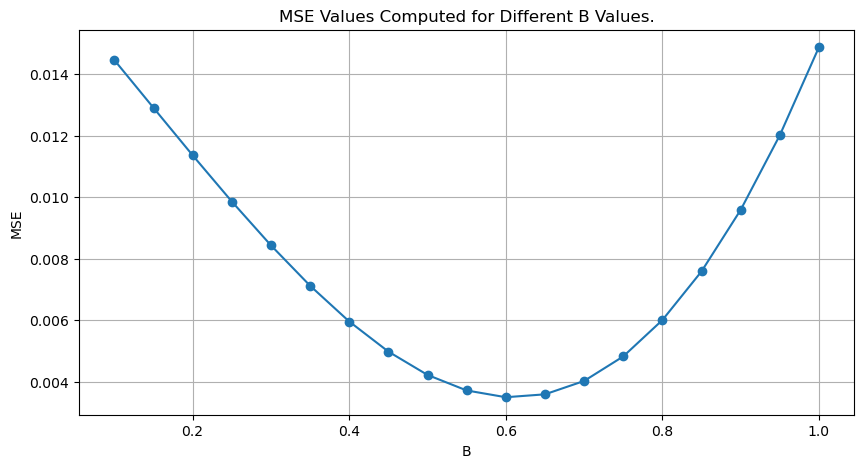

In [8]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_mse['B'], df_mse['MSE'], marker='o', linestyle='-')
plt.title('MSE Values Computed for Different B Values.')
plt.xlabel('B')
plt.ylabel('MSE')
plt.grid(True)
plt.show()

Best B = 0.6

# expand incomplete values and calibrate IV

In [9]:
def expand_incomplete_values(B):
    # Create a new date range starting from May 2025 to December 2027
    dates_extension = pd.date_range(start="2024-04-01", end="2028-01-01", freq='M')
    # Format the dates to 'Mon-YY' format
    dates_extension = dates_extension.strftime('%b-%y')

    imp_vol_extension = pd.DataFrame(dates_extension,columns = ['Date'])
    imp_vol_initial = pd.read_csv('implied_volatility.csv')
    imp_vol_extension = pd.merge(imp_vol_extension,imp_vol_initial,on = ['Date'],how = 'left')
    imp_vol_extension = cal_Future_feature(imp_vol_extension,monthly_future_prices)
    #imp_vol_extension
    
    #calibrate IV
    imp_vol_extension['sigma0^2'] = imp_vol_extension['sigma0^2'] = 2*B*imp_vol_extension['implied_volatility']**2 *imp_vol_extension['Ti-t1']/(1-np.exp(-2*B*(imp_vol_extension['Ti-t1'])))

    sig_0_apr_26_t0_mar_27 = imp_vol_extension['sigma0^2'].iloc[12:24].values 
    sig_0_apr_27_t0_dec_27 = imp_vol_extension['sigma0^2'].iloc[12:21].values 

    imp_vol_extension.loc[24:35,'sigma0^2']= sig_0_apr_26_t0_mar_27
    imp_vol_extension.loc[36:44,'sigma0^2'] = sig_0_apr_27_t0_dec_27

    imp_vol_extension['sigma^2'] = imp_vol_extension['sigma0^2']*(np.exp(-2*B*(imp_vol_extension['Ti-ts']))-np.exp(-2*B*(imp_vol_extension['Ti-t1'])))/(2*B*imp_vol_extension['ts-t1'])
    imp_vol_extension['price'] = monthly_future_prices['Monthly Curve'].iloc[:45]
    
    return imp_vol_extension

In [10]:
imp_vol_extension = expand_incomplete_values(0.6) #Best B is 0.6
imp_vol_extension

,Date,implied_volatility,Ti,ts,t1,Ti-t1,ts-t1,Ti-ts,sigma0^2,sigma^2,price
0,Apr-24,0.32895,2024-04-25,2023-12-20,2024-03-05,0.139726,-0.208219,0.347945,0.117533,0.087946,33.15
1,May-24,0.30300,2024-05-25,2023-12-20,2024-03-05,0.221918,-0.208219,0.430137,0.104575,0.070900,36.10
2,Jun-24,0.26900,2024-06-25,2023-12-20,2024-03-05,0.306849,-0.208219,0.515068,0.086499,0.052962,40.90
3,Jul-24,0.31200,2024-07-25,2023-12-20,2024-03-05,0.389041,-0.208219,0.597260,0.121828,0.067588,61.10
4,Aug-24,0.32200,2024-08-25,2023-12-20,2024-03-05,0.473973,-0.208219,0.682192,0.135950,0.068114,53.05
5,Sep-24,0.26000,2024-09-25,2023-12-20,2024-03-05,0.558904,-0.208219,0.767123,0.092784,0.041983,43.75
6,Oct-24,0.23600,2024-10-25,2023-12-20,2024-03-05,0.641096,-0.208219,0.849315,0.079840,0.032733,41.45
7,Nov-24,0.23500,2024-11-25,2023-12-20,2024-03-05,0.726027,-0.208219,0.934247,0.082732,0.030632,41.40
8,Dec-24,0.28300,2024-12-25,2023-12-20,2024-03-05,0.808219,-0.208219,1.016438,0.125108,0.041971,46.45
9,Jan-25,0.39400,2025-01-25,2024-12-20,2024-03-05,0.893151,0.794521,0.098630,0.253009,0.144886,57.65


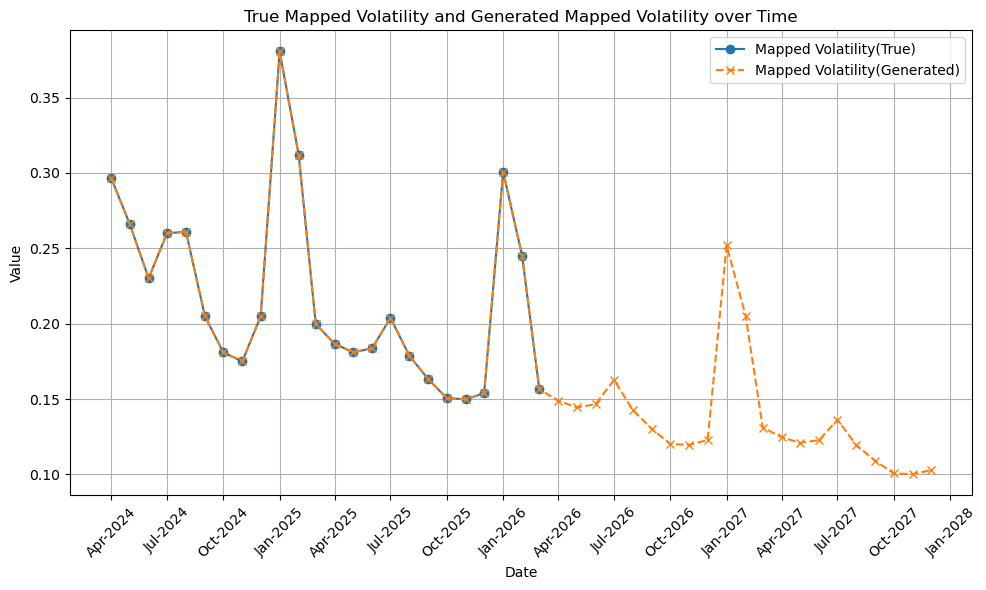

In [22]:
import matplotlib.dates as mdates
# Convert Date to a format that matplotlib can understand
imp_vol_extension['Date'] = pd.to_datetime(imp_vol_extension['Date'], format='%b-%y')


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(imp_vol_extension['Date'].iloc[:24], imp_vol_extension['sigma^2'].iloc[:24].apply(np.sqrt), marker='o', label='Mapped Volatility(True)')
plt.plot(imp_vol_extension['Date'], imp_vol_extension['sigma^2'].apply(np.sqrt), linestyle='--', marker='x', label='Mapped Volatility(Generated)')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('True Mapped Volatility and Generated Mapped Volatility over Time')
plt.legend()
plt.grid(True)

# Set x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

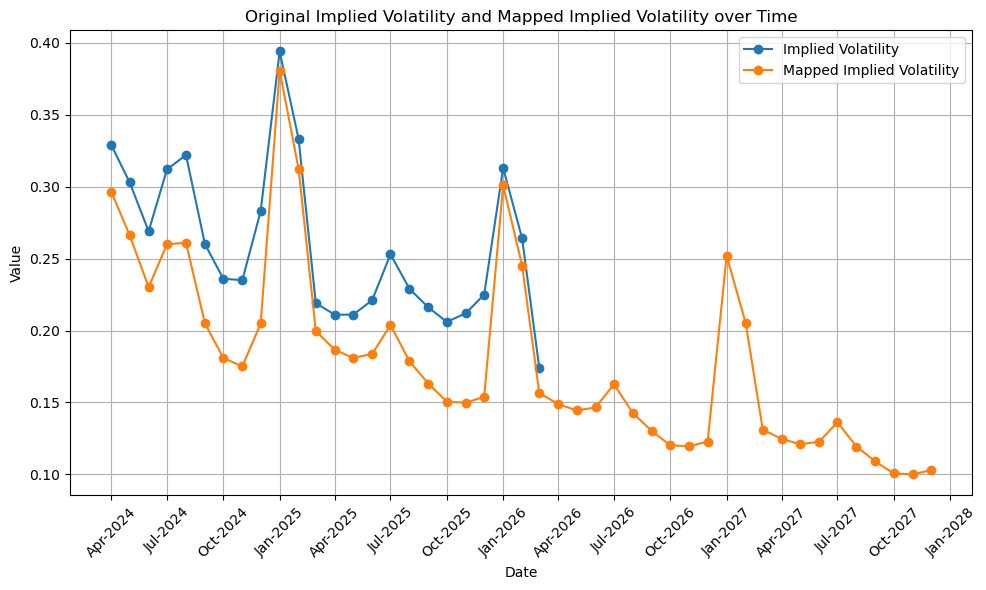

In [14]:
import matplotlib.dates as mdates
# Convert Date to a format that matplotlib can understand
imp_vol_extension['Date'] = pd.to_datetime(imp_vol_extension['Date'], format='%b-%y')


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(imp_vol_extension['Date'], imp_vol_extension['implied_volatility'], marker='o', label='Implied Volatility')
plt.plot(imp_vol_extension['Date'], imp_vol_extension['sigma^2'].apply(np.sqrt), marker='o', label='Mapped Implied Volatility')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Implied Volatility and Mapped Implied Volatility over Time')
plt.legend()
plt.grid(True)

# Set x-axis to show every month
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df_25 = imp_vol_extension[9:21].copy()
df_26 = imp_vol_extension[21:33].copy()
df_27 = imp_vol_extension[33:45].copy()

# Calculate corr matrix and set up for MM&MC  Calculation

In [13]:
# Interest rate
# https://ycharts.com/indicators/3_year_treasury_rate
r_25 = 0.0505 # 1 Year Treasury Rate (I:1YTCMR)
r_26 = 0.0472 # 2 Year Treasury Rate (I:2YTCMR)
r_27 = 0.0451 # 3 Year Treasury Rate (I:3YTCMR)
beta = 0.5

In [14]:
def corr_and_set_up(df_0,r,beta):
    """
    Calculates  M1,M2,sigma_s for Moment Matching.
    
    Args:
    df_0 (pandas.DataFrame): A DataFrame containing futures data with columns 'Date', 'implied_volatility', 
                           'Ti', 'ts', 't1', 'Ti-t1', 'ts-t1', 'Ti-ts', 'sigma^2', 'sigma^2', and 'price'.
    r (float): The annual risk-free interest rate as a decimal (e.g., 0.02 for 2%).

    Returns:
    df, Corr, M1(or strike price (K))
    """
    
    df = df_0.copy()
    
    # Calculate the discount factors
    df["DF_t1"] = np.exp(-r * df["Ti-t1"])
    df["DF_ts"] = np.exp(-r * df["Ti-ts"])

    # Calculate Omega
    df["Omega"] = df["DF_t1"] / df["DF_t1"].sum()
    
    # Extracting necessary values from the dataframe
    F = df['price'].values 
    omegas = df['Omega'].values 
    sigma_i_star = np.sqrt(df['sigma^2'].values )
    ts_t1 = df['ts-t1'].values 
    
    # Calculating Corr Matrix
    Corr = np.zeros((df.shape[0], df.shape[0]))
    for i in range(df.shape[0]):
        for j in range(df.shape[0]):
            Corr[i,j] = math.sin(math.pi*0.5*math.exp(-beta*(abs(df['Ti'].iloc[i]-df['Ti'].iloc[j]).days)/365))

    # Calculating the first moment M1
    M1 = np.sum(omegas * F)

    
    return df, Corr, M1



In [15]:
df_25_,Corr_25,M1_25= corr_and_set_up(df_25,r_25,beta)
df_26_,Corr_26,M1_26= corr_and_set_up(df_26,r_26,beta)
df_27_,Corr_27,M1_27 = corr_and_set_up(df_27,r_27,beta)


In [16]:
# strike price
K_25,K_26,K_27 = M1_25,M1_26,M1_27

In [17]:
import numpy as np
from scipy.stats import norm

def black_scholes_future(S, K, T, r, sigma, option_type="call"):
    """
    Calculate the Black-Scholes option price for European call or put.
    
    Parameters:
        S (float): stock price (or underlying asset price)
        K (float): strike price
        T (float): time to maturity (in years)
        r (float): risk-free rate (annual)
        sigma (float): volatility of the underlying asset (annual)
        option_type (str): 'call' for call option, 'put' for put option
    
    Returns:
        float: option price
    """
    # Calculate d1 and d2 parameters
    d1 = (np.log(S / K) + (0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == "call":
        # Calculate call price
        call_price = (S * norm.cdf(d1) - K * norm.cdf(d2))* np.exp(-r * T)
        return call_price
    elif option_type == "put":
        # Calculate put price
        put_price = (K * norm.cdf(-d2) - S * norm.cdf(-d1))* np.exp(-r * T)
        return put_price
    else:
        raise ValueError("Option type must be 'call' or 'put'")



# MC

In [18]:
# def calculate_swaption_price_MC(df, K, r, Corr, n_sim = 10000):
#     """
#     Calculate the swaption price using a Monte Carlo simulation method.

#     Parameters:
#         df (DataFrame): Contains the columns 'price', 'ts-t1', 'sigma^2', and 'Omega'.
#         K (float): The strike price of the swaption.
#         r (float): The risk-free rate.
#         Corr (ndarray): The correlation matrix for the multivariate normal distribution.


#     Returns:
#         float: The simulated price of the swaption.
#     """  
#     payoff = []
#     price1 = df['price'].values
    
#     for i in range(n_sim):
#         Z = multivariate_normal.rvs(np.zeros(len(df)), cov=Corr, size=1)
#         price_T = price1 * np.exp(-0.5 * df['ts-t1'] * (df['sigma^2']) + np.sqrt(df['sigma^2'] * df['ts-t1']) * Z)
#         S_T = np.sum(df['Omega'] * price_T)
#         payoff.append(max(S_T - K, 0))

#     price_swaption_sim = np.exp(-r * df['ts-t1'].iloc[0]) * np.mean(payoff)
#     return price_swaption_sim

In [19]:
def calculate_swaption_price_MC(df, K, r, Corr, n_sim=100000):
    """
    Calculate the swaption price using a Monte Carlo simulation method.

    Parameters:
        df (DataFrame): Contains the columns 'price', 'ts-t1', 'sigma^2', and 'Omega'.
        K (float): The strike price of the swaption.
        r (float): The risk-free rate.
        Corr (ndarray): The correlation matrix for the multivariate normal distribution.


    Returns:
        float: The simulated price of the swaption.
    """  
    prices = df['price'].values
    ts_t1 = df['ts-t1'].values
    sigma2 = df['sigma^2'].values
    omega = df['Omega'].values
    swaption_prices = []

    # Generate all random variables at once
    Z = multivariate_normal.rvs(mean=np.zeros(len(df)), cov=Corr, size=n_sim)
    drift = np.exp(-0.5 * ts_t1 * sigma2 + np.sqrt(sigma2 * ts_t1) * Z)

    
    # Calculate all scenarios in one go using matrix operations
    price_T_matrix= prices* drift
    S_T = np.dot(price_T_matrix, omega)       
    payoffs= np.maximum(S_T - K, 0)


    # Calculate the swaption price for this perturbation
    price_swaption = np.exp(-r * ts_t1[0]) * np.mean(payoffs)
    swaption_prices.append(price_swaption)


    return np.array(price_swaption)


In [20]:
call_price_25_MC = []
for i in range(60):
    call_price_25_MC.append(calculate_swaption_price_MC(df_25_, K_25, r_25, Corr_25))
    
swapption_price_25_mean_MC,swapption_price_25_var_MC =  np.mean(call_price_25_MC), np.var(call_price_25_MC)

print("Swapption Price 25 Mean (MC): {:.2f}".format(swapption_price_25_mean_MC))
print("Swapption Price 25 Variance (MC): {:.4f}".format(swapption_price_25_var_MC))
print("Swapption Price 25 Std Dev (MC): {:.4f}".format(np.std(call_price_25_MC)))

Swapption Price 25 Mean (MC): 3.46
Swapption Price 25 Variance (MC): 0.0003
Swapption Price 25 Std Dev (MC): 0.0168


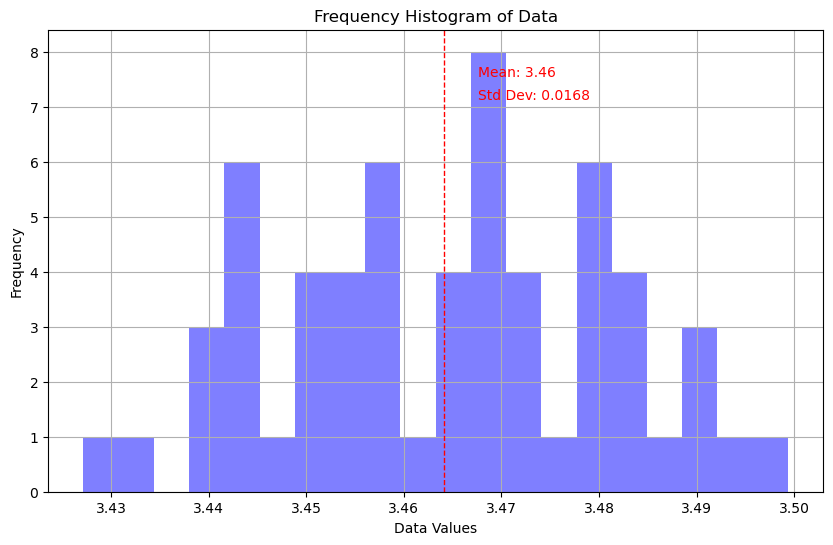

In [21]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(call_price_25_MC, bins=20, alpha=0.5, color='blue')

# Annotating mean and standard deviation on the plot
plt.axvline(np.mean(call_price_25_MC), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(call_price_25_MC) * 1.001, max_ylim * 0.9, f'Mean: {np.mean(call_price_25_MC):.2f}', color = 'red')
plt.text(np.mean(call_price_25_MC) * 1.001, max_ylim * 0.85, f'Std Dev: {np.std(call_price_25_MC):.4f}', color = 'red')

plt.title('Frequency Histogram of Data')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [22]:
call_price_26_MC = []
for i in range(60):
    call_price_26_MC.append(calculate_swaption_price_MC(df_26_, K_26, r_26, Corr_26))
    
swapption_price_26_mean_MC,swapption_price_26_var_MC =  np.mean(call_price_26_MC), np.var(call_price_26_MC)

print("Swapption Price 26 Mean (MC): {:.2f}".format(swapption_price_26_mean_MC))
print("Swapption Price 26 Variance (MC): {:.4f}".format(swapption_price_26_var_MC))
print("Swapption Price 26 Std Dev (MC): {:.4f}".format(np.std(call_price_26_MC)))

Swapption Price 26 Mean (MC): 4.22
Swapption Price 26 Variance (MC): 0.0005
Swapption Price 26 Std Dev (MC): 0.0232


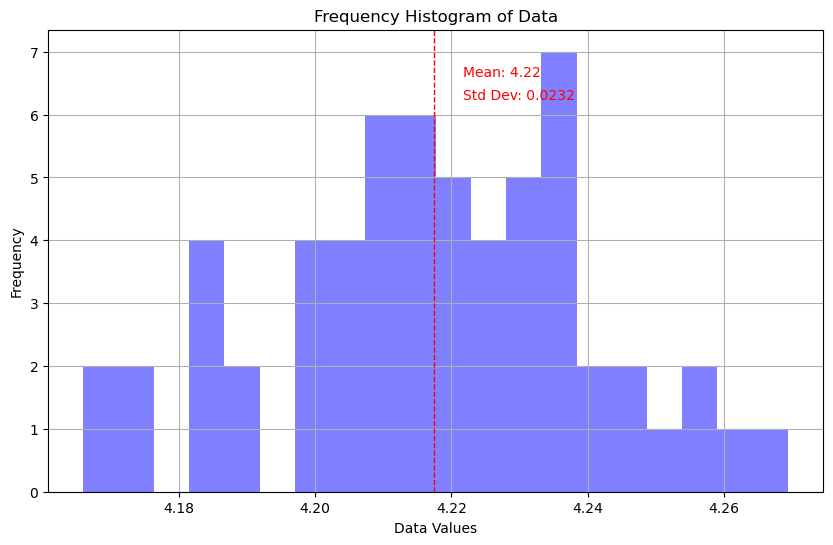

In [23]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(call_price_26_MC, bins=20, alpha=0.5, color='blue')

# Annotating mean and standard deviation on the plot
plt.axvline(np.mean(call_price_26_MC), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(call_price_26_MC) * 1.001, max_ylim * 0.9, f'Mean: {np.mean(call_price_26_MC):.2f}', color = 'red')
plt.text(np.mean(call_price_26_MC) * 1.001, max_ylim * 0.85, f'Std Dev: {np.std(call_price_26_MC):.4f}', color = 'red')

plt.title('Frequency Histogram of Data')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [24]:
call_price_27_MC = []
for i in range(60):
    call_price_27_MC.append(calculate_swaption_price_MC(df_27_, K_27, r_27, Corr_27))
    
swapption_price_27_mean_MC,swapption_price_27_var_MC =  np.mean(call_price_27_MC), np.var(call_price_27_MC)

print("Swapption Price 27 Mean (MC): {:.2f}".format(swapption_price_27_mean_MC))
print("Swapption Price 27 Variance (MC): {:.4f}".format(swapption_price_27_var_MC))
print("Swapption Price 27 Std Dev (MC): {:.4f}".format(np.std(call_price_27_MC)))

Swapption Price 27 Mean (MC): 4.24
Swapption Price 27 Variance (MC): 0.0005
Swapption Price 27 Std Dev (MC): 0.0216


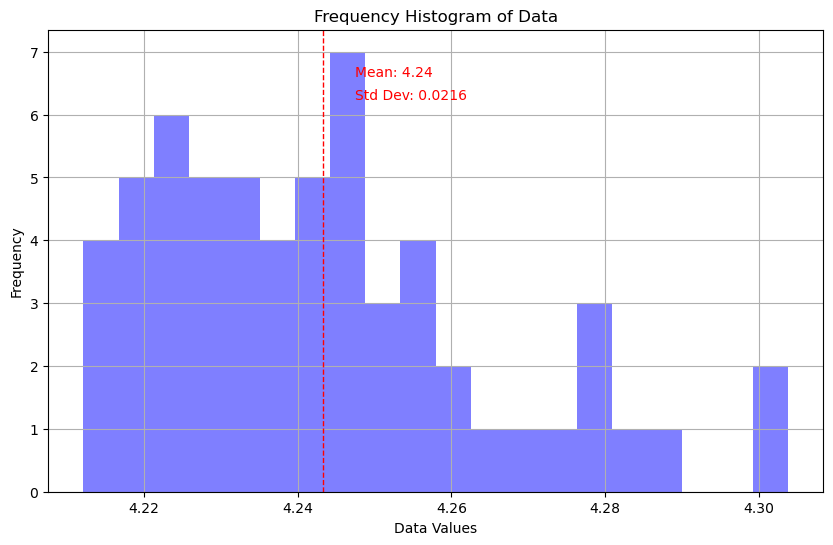

In [25]:
# Plotting histogram
plt.figure(figsize=(10, 6))
plt.hist(call_price_27_MC, bins=20, alpha=0.5, color='blue')

# Annotating mean and standard deviation on the plot
plt.axvline(np.mean(call_price_27_MC), color='red', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(call_price_27_MC) * 1.001, max_ylim * 0.9, f'Mean: {np.mean(call_price_27_MC):.2f}', color = 'red')
plt.text(np.mean(call_price_27_MC) * 1.001, max_ylim * 0.85, f'Std Dev: {np.std(call_price_27_MC):.4f}', color = 'red')

plt.title('Frequency Histogram of Data')
plt.xlabel('Data Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Model Test

(1) Test of K=0 and r=0.

In [26]:
calculate_swaption_price_MC(df_25_, 0, 0, Corr_25)

array(50.15523678)

In [27]:
df_25_['price'].mean()

50.13333333333333

In [28]:
calculate_swaption_price_MC(df_26_, 0, 0, Corr_26)

array(53.28901502)

In [29]:
df_26_['price'].mean()

53.26250000000001

In [30]:
calculate_swaption_price_MC(df_27_, 0, 0, Corr_27)

array(53.36635051)

In [31]:
df_27_['price'].mean()

53.40833333333334

(2) Test of K=infinity and r=0.

In [80]:
calculate_swaption_price_MC(df_25_, 1e+20, 0, Corr_25)

array(0.)

In [81]:
calculate_swaption_price_MC(df_26_, 1e+20, 0, Corr_26)

array(0.)

In [82]:
calculate_swaption_price_MC(df_27_, 1e+20, 0, Corr_27)

array(0.)

(3) Different values of Samuelson from weak to a very strong B = 0.00001 to B = 3.

In [102]:
#B_list = [1e-5*i for i in range(300001)]
B_list = [1e-5,2e-5,5e-5,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3]+[1e-2*i for i in range(1,301)]
swaption_price25 = []
swaption_price26 = []
swaption_price27 = []
for B_value in B_list:
    Imp_vol_extension = expand_incomplete_values(B_value)
    Df_25 = Imp_vol_extension[9:21].copy()
    Df_26 = Imp_vol_extension[21:33].copy()
    Df_27 = Imp_vol_extension[33:45].copy()
    Df_25_,CORR_25,M1_25= corr_and_set_up(Df_25,r_25,beta)
    Df_26_,CORR_26,M1_26= corr_and_set_up(Df_26,r_26,beta)
    Df_27_,CORR_27,M1_27 = corr_and_set_up(Df_27,r_27,beta)
    K_25,K_26,K_27 = M1_25,M1_26,M1_27
    swaption_price25.append(calculate_swaption_price_MC(Df_25_, K_25, r_25, CORR_25))
    swaption_price26.append(calculate_swaption_price_MC(Df_26_, K_26, r_26, CORR_26))
    swaption_price27.append(calculate_swaption_price_MC(Df_27_, K_27, r_27, CORR_27))

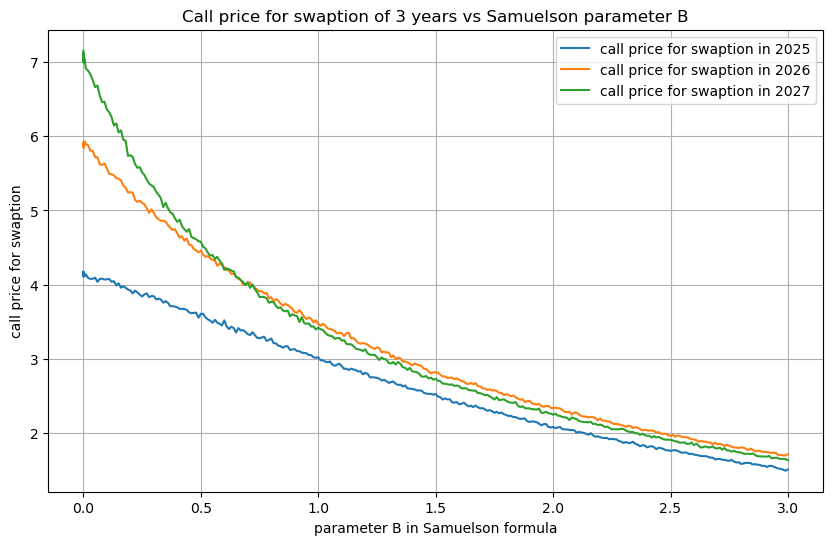

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(B_list, swaption_price25, label='call price for swaption in 2025')
plt.plot(B_list, swaption_price26, label='call price for swaption in 2026')
plt.plot(B_list, swaption_price27, label='call price for swaption in 2027')
plt.xlabel('parameter B in Samuelson formula')
plt.ylabel('call price for swaption')
plt.title('Call price for swaption of 3 years vs Samuelson parameter B')
plt.legend()
plt.grid(True)
plt.savefig('price_B.png')
plt.show()

(4) Different values of correlations parameter beta from 0 to 1 with gap 0.01 and the infinity (which means 0 correlation).

In [104]:
swaption_price25 = []
swaption_price26 = []
swaption_price27 = []
B = 0.6 #The best B we find
Imp_vol_extension = expand_incomplete_values(B)
Df_25 = Imp_vol_extension[9:21].copy()
Df_26 = Imp_vol_extension[21:33].copy()
Df_27 = Imp_vol_extension[33:45].copy()
Df_25_,CORR_25,M1_25= corr_and_set_up(Df_25,r_25,beta)
Df_26_,CORR_26,M1_26= corr_and_set_up(Df_26,r_26,beta)
Df_27_,CORR_27,M1_27 = corr_and_set_up(Df_27,r_27,beta)
K_25,K_26,K_27 = M1_25,M1_26,M1_27
zero_corr = np.diag([1 for i in range(12)])
one_corr = np.ones((12,12))
swaption_price25.append(calculate_swaption_price_MC(Df_25_, K_25, r_25, zero_corr))
swaption_price26.append(calculate_swaption_price_MC(Df_26_, K_26, r_26, zero_corr))
swaption_price27.append(calculate_swaption_price_MC(Df_27_, K_27, r_27, zero_corr))
swaption_price25.append(calculate_swaption_price_MC(Df_25_, K_25, r_25, CORR_25))
swaption_price26.append(calculate_swaption_price_MC(Df_26_, K_26, r_26, CORR_26))
swaption_price27.append(calculate_swaption_price_MC(Df_27_, K_27, r_27, CORR_27))
swaption_price25.append(calculate_swaption_price_MC(Df_25_, K_25, r_25, one_corr))
swaption_price26.append(calculate_swaption_price_MC(Df_26_, K_26, r_26, one_corr))
swaption_price27.append(calculate_swaption_price_MC(Df_27_, K_27, r_27, one_corr))

In [105]:
data_beta = pd.DataFrame({'correlation': ['0', 'Estimated', '1'], '2025':swaption_price25, '2026':swaption_price26, '2027':swaption_price27})
data_beta

,correlation,2025,2026,2027
0,0,1.1312338562208315,1.3867618738854761,1.4045952228705878
1,Estimated,3.462612069841256,4.21811442874664,4.267209010143732
2,1,3.529104719107431,4.30951585223523,4.295110624934958


# Moment matching

In [92]:
# import numpy as np

# def calculate_sigma_swaption_price_MM(df,M1,r, Corr):
#     """
#     Calculate the weighted standard deviation sigma_s based on given data and correlation matrix.

#     Parameters:
#         df (DataFrame): Must contain the columns 'Omega', 'price', and 'sigma^2', 'ts-t1'.
#         Corr (ndarray): The correlation matrix.
#         M1 (float): The first moment (mean) of the underlying distribution.

#     Returns:
#         float: The calculated standard deviation sigma_s.
#     """
#     n = len(df)
#     weight = df['Omega'].values
#     price = df['price'].values
#     vol_imp = np.sqrt(df['sigma^2']).values
#     diff_t = df['ts-t1'].values[0] 
#     M2_matrix = np.zeros([n, n])

#     for i in range(n):
#         for j in range(n):
#             M2_matrix[i, j] = weight[i] * price[i] * weight[j] * price[j] * (np.exp(Corr[i, j] * vol_imp[i] * vol_imp[j] * diff_t) - 1)

#     M2 = np.sum(M2_matrix)
#     sigma_s = np.sqrt(np.log(M2 / M1**2 + 1) / diff_t)
    
#     K = M1
#     opt_price = black_scholes_future(M1, K, diff_t, r, sigma_s, option_type="call")
    
#     return sigma_s,opt_price


In [33]:
import numpy as np

def calculate_sigma_swaption_price_MM(df,M1,r, Corr):
    """
    Calculate the weighted standard deviation sigma_s based on given data and correlation matrix.

    Parameters:
        df (DataFrame): Must contain the columns 'Omega', 'price', and 'sigma^2', 'ts-t1'.
        Corr (ndarray): The correlation matrix.
        M1 (float): The first moment (mean) of the underlying distribution.

    Returns:
        float: The calculated standard deviation sigma_s.
    """
    n = len(df)
    omegas = df['Omega'].values
    price = df['price'].values
    sigma_i_star = np.sqrt(df['sigma^2']).values
    diff_t = df['ts-t1'].values[0] 
    
    
    M2 = 0
    for k in range(n):
        for j in range(n):
            rho_kj = Corr[k][j]  
            M2 += omegas[k] * omegas[j] * price[k] * price[j] * (np.exp(rho_kj * sigma_i_star[k] * sigma_i_star[j] * diff_t) - 1)
    
    # Calculating the volatility sigma_s   
    sigma_s = np.sqrt(np.log(M2 / M1**2 + 1) / diff_t)
    
    K = M1
    opt_price = black_scholes_future(M1, K, diff_t, r, sigma_s, option_type="call")
    
    return sigma_s,opt_price


In [34]:
sigma_s_25_MM, swapption_price_25_MM =  calculate_sigma_swaption_price_MM(df_25_, K_25, r_25, Corr_25)

print("Swapption Price 25 (MM): {:.2f}".format(swapption_price_25_MM))
print("Sigma_s 25 (MM): {:.4f}".format(sigma_s_25_MM))



Swapption Price 25 (MM): 3.48
Sigma_s 25 (MM): 0.2033


In [35]:
sigma_s_26_MM, swapption_price_26_MM =  calculate_sigma_swaption_price_MM(df_26_, K_26, r_26, Corr_26)

print("Swapption Price 26 (MM): {:.2f}".format(swapption_price_26_MM))
print("Sigma_s 26 (MM): {:.4f}".format(sigma_s_26_MM))

Swapption Price 26 (MM): 4.24
Sigma_s 26 (MM): 0.1624


In [36]:
sigma_s_27_MM, swapption_price_27_MM =  calculate_sigma_swaption_price_MM(df_27_, K_27, r_27, Corr_27)

print("Swapption Price 27 (MM): {:.2f}".format(swapption_price_27_MM))
print("Sigma_s 27 (MM): {:.4f}".format(sigma_s_27_MM))

Swapption Price 27 (MM): 4.27
Sigma_s 27 (MM): 0.1361


# Real price

In [37]:
black_scholes_future(M1_25, K_25, df_25['ts-t1'].iloc[0],r_25, 0.294, option_type="call")

5.0198823304860944

In [38]:
black_scholes_future(M1_26, K_26, df_26['ts-t1'].iloc[0],r_26, 0.283, option_type="call")

7.357034214500585

In [39]:
black_scholes_future(M1_27, K_27, df_27['ts-t1'].iloc[0],r_27, 0.272, option_type="call")

8.468803356666527

# Calculate Deltas w.r.t forward prices

## numerical

In [40]:
import warnings

# Suppress specific pandas warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)



In [41]:
def calculate_swaption_price_MC_for_delta_cal(df, K, r, Corr, epsilon, n_sim=100000):
    """
    Calculate the swaption prices using a Monte Carlo simulation method, adjusting each
    price entry by epsilon one at a time and then computing the swaption price using
    matrix operations to run simulations only once.

    Parameters:
        df (DataFrame): Contains the columns 'price', 'ts-t1', 'sigma^2', and 'Omega'.
        K (float): The strike price of the swaption.
        r (float): The risk-free rate.
        Corr (ndarray): The correlation matrix for the multivariate normal distribution.
        epsilon (float): The small change to apply to each price for sensitivity analysis.
        n_sim (int): Number of simulations to run (default 10000).

    Returns:
        ndarray: An array of simulated swaption prices for each perturbation.
    """
    original_prices = df['price'].values
    ts_t1 = df['ts-t1'].values
    sigma2 = df['sigma^2'].values
    omega = df['Omega'].values
    swaption_prices_up = []
    swaption_prices_down = []

    # Generate all random variables at once
    Z = multivariate_normal.rvs(mean=np.zeros(len(df)), cov=Corr, size=n_sim)
    drift = np.exp(-0.5 * ts_t1 * sigma2 + np.sqrt(sigma2 * ts_t1) * Z)

    
    for k in range(len(original_prices)):
        # Create a new price array for the k-th perturbation
        perturbed_prices_up = np.array(original_prices, copy=True)
        perturbed_prices_up[k] += epsilon  # Add epsilon to the k-th element
        
        perturbed_prices_down = np.array(original_prices, copy=True)
        perturbed_prices_down[k] -= epsilon  # Add epsilon to the k-th element

        # Calculate all scenarios in one go using matrix operations
        price_T_matrix_up , price_T_matrix_down  = perturbed_prices_up * drift , perturbed_prices_down * drift 
        S_T_up, S_T_down = np.dot(price_T_matrix_up, omega) , np.dot(price_T_matrix_down, omega)        
        payoffs_up, payoffs_down = np.maximum(S_T_up - K, 0),np.maximum(S_T_down - K, 0)
        
        
        # Calculate the swaption price for this perturbation
        price_swaption_sim_up = np.exp(-r * ts_t1[0]) * np.mean(payoffs_up)
        swaption_prices_up.append(price_swaption_sim_up)
        price_swaption_sim_down = np.exp(-r * ts_t1[0]) * np.mean(payoffs_down)
        swaption_prices_down.append(price_swaption_sim_down)

    return np.array(swaption_prices_up),np.array(swaption_prices_down)


In [42]:
def cal_delta_MC(df, K , r, Corr,epsilon):
    up,down = calculate_swaption_price_MC_for_delta_cal(df, K, r, Corr,epsilon)
    return (up-down)/2

In [43]:
# def calculate_deltas_MM(df_0, K , r, Corr, epsilon=1):
    
#     df = df_0.copy()
        
#     # Store the original deltas in a list
#     deltas = []
    
#     # Iterate over each price in the DataFrame
#     for i in range(len(df['price'])):  
        
#         # Store original price
#         original_price = df['price'].iloc[i]
        
                
#         # Increment the price
#         df['price'].iloc[i] = original_price + epsilon
#         swaption_MM_up = calculate_sigma_swaption_price_MM(df, K , r, Corr)[1]
        
#         # Decrement the price
#         df['price'].iloc[i] = original_price - epsilon
#         swaption_MM_down = calculate_sigma_swaption_price_MM(df, K , r, Corr)[1]
        
#         # Restore the original price
#         df['price'].iloc[i] = original_price
        
#         # Calculate the derivative (Delta)
#         delta_MM = (swaption_MM_up - swaption_MM_down) / (2 * epsilon)
        
#         deltas.append([delta_MM])
        
#     return deltas

In [44]:
# calculate_deltas_MM(df_25_, K_25 , r_25, Corr_25 )

In [45]:
# def MC_MM_swp(df, K , r, Corr, beta=0.5):
#     swaption_MM = calculate_sigma_swaption_price_MM(df, K , r, Corr)[1]
#     swaption_MC  = calculate_swaption_price_MC(df, K , r, Corr, n_sim = 10000)
    
#     return swaption_MC,swaption_MM
    

# def calculate_deltas(df_0, K , r, Corr, epsilon=5):
    
#     df = df_0.copy()
        
#     # Store the original deltas in a list
#     deltas = []
    
#     # Iterate over each price in the DataFrame
#     for i in range(len(df['price'])):  
        
#         # Store original price
#         original_price = df['price'].iloc[i]
        
                
#         # Increment the price
#         df['price'].iloc[i] = original_price + epsilon
#         swaption_MC_up,swaption_MM_up = MC_MM_swp(df, K , r, Corr)
        
#         # Decrement the price
#         df['price'].iloc[i] = original_price - epsilon
#         swaption_MC_down,swaption_MM_down = MC_MM_swp(df, K , r, Corr)
        
#         # Restore the original price
#         df['price'].iloc[i] = original_price
        
#         # Calculate the derivative (Delta)
#         delta_MC = (swaption_MC_up - swaption_MC_down) / (2 * epsilon)
#         delta_MM = (swaption_MM_up - swaption_MM_down) / (2 * epsilon)
        
#         deltas.append([delta_MC,delta_MM])
        
#     return deltas

In [46]:
# deltas_25 = calculate_deltas(df_25_, K_25 , r_25, Corr_25 )
# df_deltas_25 = pd.DataFrame(deltas_25,columns = ['delta_MC','delta_MomentMatching'],index = df_25_['Date'])
# df_deltas_25

## analytical

In [47]:
def cal_delta_analytical(r, df_0, Corr, i):
    #Future index from 1 to 12
    df = df_0.copy()
    
    # Calculate the discount factors
    df["DF_t1"] = np.exp(-r * df["Ti-t1"])
    df["DF_ts"] = np.exp(-r * df["Ti-ts"])

    # Calculate Omega
    df["Omega"] = df["DF_t1"] / df["DF_t1"].sum()
    
    # Extracting necessary values from the dataframe
    F = df['price'].values 
    omegas = df['Omega'].values 
    sigma_i_star = np.sqrt(df['sigma^2'].values )
    ts_t1 = df['ts-t1'].values 
    
    # Calculating the first moment M1
    M1 = np.sum(omegas * F)
    
    # Calculating the second moment M2
    #M2 = np.sum(omegas**2 * F**2 * (np.exp((sigma_i_star**2) * ts_t1) - 1))
    M2 = 0
    for k in range(len(F)):
        for j in range(len(F)):
            #if k != j:
            rho_kj = Corr[k][j]  # This would come from the actual correlation matrix
            M2 += omegas[k] * omegas[j] * F[k] * F[j] * (np.exp(rho_kj * sigma_i_star[k] * sigma_i_star[j] * ts_t1[0]) - 1)
    
    # Calculating the volatility sigma_s
    sigma_s = np.sqrt(np.log(M2 / M1**2 + 1) / ts_t1[0])
    
    pM1_pFi = omegas[i]
    pM2_pFi = 0
    for j in range(len(F)):
        #if k != j:
        rho_ij = Corr[i][j]  # This would come from the actual correlation matrix
        rho_ji = Corr[j][i]
        Bij = np.exp(rho_ij * sigma_i_star[i] * sigma_i_star[j] * ts_t1[0]) - 1
        Bji = np.exp(rho_ji * sigma_i_star[j] * sigma_i_star[i] * ts_t1[0]) - 1
        pM2_pFi += omegas[i] * omegas[j] * F[j] * (Bij+Bji)
    psigmas_pM1 = -M2/(ts_t1[0]*sigma_s*M1*(M1**2+M2))
    psigmas_pM2 = 1/(2*ts_t1[0]*sigma_s*(M1**2+M2))
    psigmas_pFi = psigmas_pM1 * pM1_pFi + psigmas_pM2 *pM2_pFi
    
    K = M1
    T = ts_t1[0]
    d1 = (np.log(M1 / K) + (0.5 * sigma_s**2) * T) / (sigma_s * np.sqrt(T))
    d2 = d1 - sigma_s * np.sqrt(T)
    pd1_pM1 = 1/(sigma_s*M1*np.sqrt(T))
    pd2_pM1 = 1/(sigma_s*M1*np.sqrt(T))
    pd1_psigmas = np.sqrt(T) - (np.log(M1/K)+(0.5*sigma_s**2)*T)/(np.sqrt(T)*sigma_s**2)
    pd2_psigmas = pd1_psigmas - np.sqrt(T)
    pd1_pFi = pd1_pM1*pM1_pFi + pd1_psigmas*psigmas_pFi
    pd2_pFi = pd2_pM1*pM1_pFi + pd2_psigmas*psigmas_pFi
    pS_pM1 = np.exp(-r*T)*norm.cdf(d1)
    pS_pd1 = M1*np.exp(-r*T)*norm.pdf(d1)
    pS_pd2 = -K*np.exp(-r*T)*norm.pdf(d2)
    pS_pFi = pS_pM1*pM1_pFi + pS_pd1*pd1_pFi + pS_pd2*pd2_pFi
    return pS_pFi

In [48]:
def delta_compare(df, K, r, Corr,epsilon):
    pS_pFi = []
    Date = df['Date']
    for i in range(df.shape[0]):
        pS_pFi.append(cal_delta_analytical(r, df, Corr, i))
        
    delta_MC = cal_delta_MC(df, K , r, Corr,epsilon)
    
    delta = pd.DataFrame({'Date': Date, 'Delta__analytical':pS_pFi,'Delta_MC':delta_MC})
    return(delta)

In [49]:
delta_compare(df_25_, K_25 , r_25, Corr_25,epsilon=1)

,Date,Delta__analytical,Delta_MC
9,Jan-25,0.048812,0.048442
10,Feb-25,0.046733,0.046456
11,Mar-25,0.043387,0.043164
12,Apr-25,0.042860,0.042638
13,May-25,0.042538,0.042319
14,Jun-25,0.042431,0.042214
15,Jul-25,0.042807,0.042595
16,Aug-25,0.041888,0.041677
17,Sep-25,0.041239,0.041027
18,Oct-25,0.040684,0.040470


In [50]:
delta_compare(df_26_, K_26 , r_26, Corr_26,epsilon=1)

,Date,Delta__analytical,Delta_MC
21,Jan-26,0.048020,0.047669
22,Feb-26,0.045618,0.045399
23,Mar-26,0.041863,0.041713
24,Apr-26,0.041418,0.041270
25,May-26,0.041093,0.040946
26,Jun-26,0.041013,0.040872
27,Jul-26,0.041485,0.041351
28,Aug-26,0.040476,0.040340
29,Sep-26,0.039777,0.039637
30,Oct-26,0.039184,0.039039


In [51]:
delta_compare(df_27_, K_27 , r_27, Corr_27,epsilon=1)

,Date,Delta__analytical,Delta_MC
33,Jan-27,0.046426,0.045983
34,Feb-27,0.044026,0.043709
35,Mar-27,0.040273,0.040002
36,Apr-27,0.039841,0.039567
37,May-27,0.039527,0.039251
38,Jun-27,0.039461,0.039184
39,Jul-27,0.039946,0.039674
40,Aug-27,0.038948,0.038666
41,Sep-27,0.038261,0.037966
42,Oct-27,0.037680,0.037373
